### Load Data

In [ ]:
import os
import warnings
import pandas as pd

def process_stock_data(folder_path, start_date='2010-01-01'):
    
    warnings.filterwarnings("ignore")
    
    # Get list of ticker names from CSV files
    tickers = [f[:-4] for f in os.listdir(folder_path) if f.endswith(".csv")]
    
    dfs = {}
    
    for ticker in tickers:
        file_path = os.path.join(folder_path, f"{ticker}.csv")
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {ticker}: {e}")
            continue
            
        # Strip extra date info (e.g. exact time)
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'].astype(str).str.slice(0, 10), 
                                      errors='coerce')
        else:
            print(f"No 'Date' column found in {ticker}. Skipping.")
            continue
            
        required_cols = {'Date', 'Open', 'High', 'Low', 'Close'}
        if not required_cols.issubset(df.columns):
            print(f"Missing columns in {ticker}. Skipping.")
            continue
            
        df.set_index('Date', inplace=True)
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']].sort_index()
        
        dfs[ticker] = df
    
    # Concatenate all DataFrames
    combined_df = pd.concat(dfs, axis=1)
    
    # Sort the combined DataFrame by date index
    combined_df.sort_index(inplace=True)
    
    # Convert wide format to long format
    long_df = combined_df.stack(level=0).reset_index()
    
    # Rename columns
    long_df.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
    
    # Filter by start date
    long_df = long_df[long_df['Date'] > start_date].copy()
    
    return long_df

folder_path = r"C:\Users\6eggr\Desktop\Python\New folder\daily_data"
long_df = process_stock_data(folder_path)
long_df.head(5)

,Date,Ticker,Open,High,Low,Close,Volume
2465320,2010-01-04,A,20.110686,20.264448,19.944111,20.053026,3815561.0
2465321,2010-01-04,AAPL,6.429939,6.462175,6.398307,6.447413,493729600.0
2465322,2010-01-04,ABT,18.670688,18.798169,18.577661,18.763714,10829095.0
2465323,2010-01-04,ACGL,7.587114,7.628319,7.580774,7.601905,4813200.0
2465324,2010-01-04,ACN,31.52421,32.040503,31.509025,31.941799,3650100.0


### Create Features

In [3]:
def create_features(df):
    import numpy as np
    import pandas_ta as ta
    df = df.sort_values('Date')

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)

    # Moving Averages and EMAs
    df['5_EMA'] = ta.ema(df['Close'], length=5)
    df['10_MA'] = df['Close'].rolling(window=10).mean()
    df['20_MA'] = df['Close'].rolling(window=20).mean()  
    df['50_MA'] = df['Close'].rolling(window=50).mean()

    # Bollinger Bands + BB Width
    df['20_STD'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_MA'] + (2 * df['20_STD'])
    df['Lower_Band'] = df['20_MA'] - (2 * df['20_STD'])
    df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['Close']

    # Body Size + Relative Body Size
    period = 5
    df['Range'] = df['High'] - df['Low'] 
    df['Range'].replace(0, np.nan, inplace=True)  
    df['BodySize'] = (df['Close'] - df['Open']) / df['Range']

    # Percent Change for short and long periods + Crossover
    short_period = 5
    long_period = 10
    df['Short_Change'] = df['Close'].pct_change(periods=short_period) * 100  
    df['Long_Change'] = df['Close'].pct_change(periods=long_period) * 100 
    df['Crossover'] = np.where(df['Short_Change'] > df['Long_Change'], 1, -1)

    df.drop(columns=['Range'], inplace=True)

    # Add percentage change over the past 1, 3, 6, and 12 months
    month_periods = {'1_Month': 21, '3_Months': 63, '6_Months': 126, '12_Months': 252}
    for label, period in month_periods.items():
        df[f'Pct_Change_{label}'] = df['Close'].pct_change(periods=period) * 100

    return df

In [4]:
import numpy as np
def create_binary_features(df):
    df = df.sort_values('Date').copy()


    df['BodySize'] = np.where(df['BodySize'] > 0.5, 1,
                              np.where(df['BodySize'] < (-0.5), -1, 0))    
    df['RSI_Signal'] = np.where(df['RSI'] > 70, 1,
                                np.where(df['RSI'] < 30, -1, 0))
    df['Gap'] = np.where(df['Close'].pct_change(periods=1).fillna(0) > 0, 1, -1)
    df['Outside_Band'] = np.where(df['Close'] > df['Upper_Band'], 1,
                                  np.where(df['Close'] < df['Lower_Band'], -1, 0))
    df['Short_Change'] = np.where(df['Short_Change'] > 0, 1, -1)
    df['Long_Change'] = np.where(df['Long_Change'] > 0, 1, -1)
    df['Pct_Change_3_Months'] = np.where(df['Pct_Change_3_Months'] > 0, 1, -1)
    df['Pct_Change_1_Month'] = np.where(df['Pct_Change_1_Month'] > 0, 1, -1)
    df['Pct_Change_6_Months'] = np.where(df['Pct_Change_6_Months'] > 0, 1, -1)
    df['Pct_Change_12_Months'] = np.where(df['Pct_Change_12_Months'] > 0, 1, -1)

    # EMA and SMA slopes
    df['5_EMA_Slope'] = np.where(df['5_EMA'].diff().fillna(0) > 0, 1, -1)
    df['10_SMA_Slope'] = np.where(df['10_MA'].diff().fillna(0) > 0, 1, -1)
    df['50_SMA_Slope'] = np.where(df['50_MA'].diff().fillna(0) > 0, 1, -1)
    df['20_MA_Slope'] = np.where(df['20_MA'].diff().fillna(0) > 0, 1, -1)


    # Binary variables for price relative to SMAs
    df['Above_10_SMA'] = np.where(df['Close'] > df['10_MA'], 1, -1)
    df['Above_20_SMA'] = np.where(df['Close'] > df['20_MA'], 1, -1)
    df['Above_50_SMA'] = np.where(df['Close'] > df['50_MA'], 1, -1)

    # Binary columns
    binary_columns = ['BodySize', '20_MA_Slope', 'RSI_Signal', 'Gap', 'Outside_Band',
                      'Short_Change', 'Long_Change', 'Pct_Change_3_Months',
                      'Pct_Change_1_Month', 'Pct_Change_6_Months', 'Pct_Change_12_Months',
                      '5_EMA_Slope', '10_SMA_Slope', '50_SMA_Slope', 'Above_10_SMA',
                      'Above_20_SMA', 'Above_50_SMA']

    df['Vote_Count'] = df[binary_columns].sum(axis=1)

    columns_to_keep = ['Date', 'Ticker', 'Close', 'Open', 'BB_Width'] + binary_columns + ['Vote_Count']

    return df[columns_to_keep]


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
df = long_df.groupby('Ticker', group_keys=False).apply(create_features)
df = df.groupby('Ticker').apply(create_binary_features).reset_index(drop=True).dropna()

In [6]:
df.head()

,Date,Ticker,Close,Open,BB_Width,BodySize,20_MA_Slope,RSI_Signal,Gap,Outside_Band,Short_Change,Long_Change,Pct_Change_3_Months,Pct_Change_1_Month,Pct_Change_6_Months,Pct_Change_12_Months,5_EMA_Slope,10_SMA_Slope,50_SMA_Slope,Above_10_SMA,Above_20_SMA,Above_50_SMA,Vote_Count
19,2010-02-01,A,18.66,18.04,0.13,1,-1,0,1,0,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-9
20,2010-02-02,A,18.90,18.72,0.12,1,-1,0,1,0,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-5
21,2010-02-03,A,18.93,18.83,0.12,0,-1,0,1,0,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-6
22,2010-02-04,A,18.62,18.77,0.12,0,-1,0,-1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-12
23,2010-02-05,A,18.69,18.52,0.12,0,-1,0,1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-8


### Select stocks with highest volatility and at least four years of price data

In [7]:
four_years_ago = df['Date'].max() - pd.Timedelta(days=4*365)
valid_tickers = df.groupby('Ticker').filter(lambda x: x['Date'].min() <= four_years_ago)['Ticker'].unique()
filtered_df = df[df['Ticker'].isin(valid_tickers)]
bb_width_dict = filtered_df.groupby('Ticker')['BB_Width'].median().to_dict()
top_20 = sorted(bb_width_dict.items(), key=lambda x: x[1], reverse=True)[:20]
for ticker, width in top_20: print(f"Ticker: {ticker}, BB_Width: {width}")

Ticker: ENPH, BB_Width: 0.29041689968591067
Ticker: MRNA, BB_Width: 0.273866258487024
Ticker: PLTR, BB_Width: 0.24969878944737153
Ticker: CRWD, BB_Width: 0.21445442909025786
Ticker: AMD, BB_Width: 0.19966344973696581
Ticker: TSLA, BB_Width: 0.19722335848807399
Ticker: FSLR, BB_Width: 0.18679398555367546
Ticker: UBER, BB_Width: 0.17936545848529373
Ticker: BLDR, BB_Width: 0.17597969180351672
Ticker: SMCI, BB_Width: 0.17555431454712972
Ticker: MU, BB_Width: 0.1719459901034123
Ticker: AXON, BB_Width: 0.17155517254029387
Ticker: FCX, BB_Width: 0.17131870339003585
Ticker: CZR, BB_Width: 0.1699772948153561
Ticker: NFLX, BB_Width: 0.16499605536847933
Ticker: DAY, BB_Width: 0.16076839164820653
Ticker: URI, BB_Width: 0.1607316374392878
Ticker: NVDA, BB_Width: 0.15754565346271301
Ticker: UAL, BB_Width: 0.15693603375425708
Ticker: DXCM, BB_Width: 0.1563902032589669


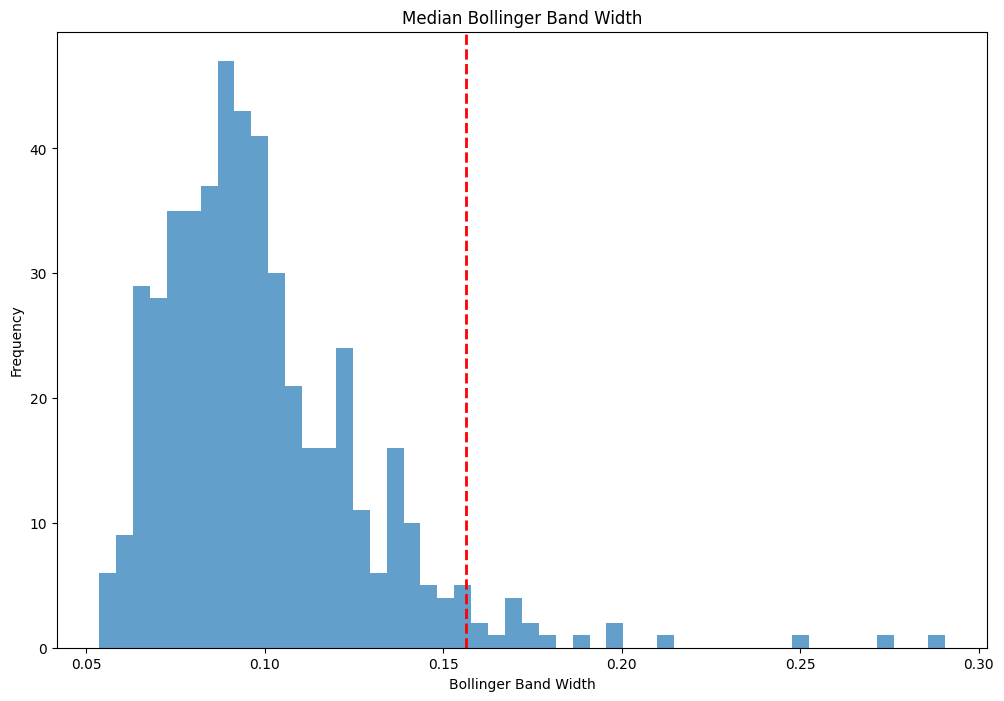

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.hist(bb_width_dict.values(), bins=50, alpha=0.7)
plt.axvline(min(dict(top_20).values()), color='red', linestyle='dashed', linewidth=2, label='Lowest in top 20')
plt.title('Median Bollinger Band Width')
plt.xlabel('Bollinger Band Width')
plt.ylabel('Frequency')
plt.show()


In [9]:
top_tickers = [ticker for ticker, _ in top_20]
filtered_df = df[df['Ticker'].isin(top_tickers)]
filtered_df.head(10)

,Date,Ticker,Close,Open,BB_Width,BodySize,20_MA_Slope,RSI_Signal,Gap,Outside_Band,Short_Change,Long_Change,Pct_Change_3_Months,Pct_Change_1_Month,Pct_Change_6_Months,Pct_Change_12_Months,5_EMA_Slope,10_SMA_Slope,50_SMA_Slope,Above_10_SMA,Above_20_SMA,Above_50_SMA,Vote_Count
92907,2010-02-01,AMD,7.98,7.61,0.34,1,-1,0,1,0,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-9
92908,2010-02-02,AMD,7.91,7.74,0.34,1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-13
92909,2010-02-03,AMD,7.81,7.83,0.33,0,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-14
92910,2010-02-04,AMD,7.19,7.64,0.38,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-16
92911,2010-02-05,AMD,7.35,7.13,0.37,1,-1,0,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-11
92912,2010-02-08,AMD,7.42,7.38,0.35,0,-1,0,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-12
92913,2010-02-09,AMD,7.54,7.59,0.34,0,-1,0,1,0,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-10
92914,2010-02-10,AMD,7.64,7.47,0.33,1,-1,0,1,0,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-7
92915,2010-02-11,AMD,7.84,7.67,0.30,1,-1,0,1,0,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-5
92916,2010-02-12,AMD,7.87,7.71,0.28,0,-1,0,1,0,1,1,-1,-1,-1,-1,1,1,-1,1,-1,-1,-2


In [15]:
from itertools import combinations
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd
import numpy as np

def execute_trading_strategy(df, selected_features, entry_threshold=0.8, exit_threshold=0.7):
    results_by_ticker = {}
    daily_returns_df = pd.DataFrame()  

    # Group by ticker and apply the strategy
    for ticker, ticker_data in df.groupby('Ticker'):
        results = ticker_data.copy()

        # Ensure 'Open' column is numeric and clean invalid values
        results['Open'] = pd.to_numeric(results['Open'], errors='coerce')
        results.dropna(subset=['Open'], inplace=True)
        results['Open'] = results['Open'].clip(lower=1e-6)  # Prevent divide-by-zero errors

        # Validate selected_features
        selected_features = [col for col in selected_features if col in results.columns]
        if not selected_features:
            continue

        # Calculate vote percentage
        vote_count = results[selected_features].sum(axis=1)
        total_voters = len(selected_features)
        vote_percentage = vote_count / total_voters

        # Initialize position column
        results['Position'] = 0
        current_position = 0

        # Trading logic
        for i in range(1, len(results)):
            prev_votes = vote_percentage.iloc[i - 1]

            if current_position == 0:
                # Enter positions
                if prev_votes >= entry_threshold:
                    current_position = 1
                elif prev_votes <= -entry_threshold:
                    current_position = -1
            else:
                # Exit positions
                if current_position == 1 and prev_votes < exit_threshold:
                    current_position = 0
                elif current_position == -1 and prev_votes > -exit_threshold:
                    current_position = 0

            results.loc[results.index[i], 'Position'] = current_position

        # Calculate returns
        results['Returns'] = np.log(results['Open'] / results['Open'].shift(1))

        # Strategy returns: position (shifted by 1) times returns
        results['Strategy_Returns'] = results['Position'].shift(1).fillna(0) * results['Returns']
        daily_returns_df[ticker] = results['Strategy_Returns']

        # Cumulative metrics
        results['Cumulative_Returns'] = (1 + results['Strategy_Returns']).cumprod()
        results['Equity_Curve'] = results['Cumulative_Returns'] * 1000  # Starting equity

        # Performance metrics
        total_return = results['Cumulative_Returns'].iloc[-1] - 1
        returns_std = results['Strategy_Returns'].std()
        sharpe_ratio = np.sqrt(252) * (results['Strategy_Returns'].mean() / returns_std) if returns_std != 0 else 0
        equity_max = results['Cumulative_Returns'].expanding().max()
        drawdown = (results['Cumulative_Returns'] / equity_max) - 1
        max_drawdown = drawdown.min()

        # Store per-ticker results
        results_by_ticker[ticker] = {
            'results': results,
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown
        }

    # Aggregate metrics
    aggregate_metrics = {
        'mean_sharpe': np.mean([v['sharpe_ratio'] for v in results_by_ticker.values()]),
        'total_sharpe': np.sum([v['sharpe_ratio'] for v in results_by_ticker.values()]),
        'mean_return': np.mean([v['total_return'] for v in results_by_ticker.values()]),
        'worst_drawdown': min([v['max_drawdown'] for v in results_by_ticker.values()]),
        'number_of_stocks': len(results_by_ticker),
        'daily_returns': daily_returns_df
    }

    return {
        'results_by_ticker': results_by_ticker,
        'aggregate_metrics': aggregate_metrics,
        'selected_features': selected_features
    }


def plot_daily_returns(strategy_result, window=20):
    
    equity_curves = pd.DataFrame()
    for ticker, data in strategy_result['results_by_ticker'].items():
        temp_df = data['results'].copy()
        if 'Date' in temp_df.columns:
            temp_df.set_index('Date', inplace=True)
        equity_curves[ticker] = temp_df['Equity_Curve']
    
    plt.figure(figsize=(15, 8))
    
    for column in equity_curves.columns:
        plt.plot(equity_curves.index, equity_curves[column], label=column)
    
    plt.title('Equity Curves by Stock')
    plt.xlabel('Date')
    plt.ylabel('Equity Curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    
    return plt.gcf()


def analyze_best_strategy(strategy_result):
    
    print("Strategy Configuration:")
    print(f"Features ({len(strategy_result['features'])} total):")
    for feat in strategy_result['features']:
        print(f"- {feat}")
    print(f"\nEntry threshold: {strategy_result['entry_threshold']}")
    print(f"Exit threshold: {strategy_result['exit_threshold']}\n")
    
    print("Aggregate Metrics:")
    for metric, value in strategy_result['aggregate_metrics'].items():
        if isinstance(value, (int, float)):  
            print(f"{metric}: {value:.4f}")
    
    performance_df = pd.DataFrame({
        ticker: {
            'Sharpe': data['sharpe_ratio'],
            'Total Return': data['total_return'],
            'Max Drawdown': data['max_drawdown'],
            'Final Equity': data['results']['Equity_Curve'].iloc[-1]
        }
        for ticker, data in strategy_result['results_by_ticker'].items()
    }).T
    
    performance_df.loc['Mean'] = performance_df.mean()
    performance_df.loc['Median'] = performance_df.median()
    performance_df.loc['Std'] = performance_df.std()
    
    
    returns_fig = plot_daily_returns(strategy_result)
    
    return performance_df, returns_fig

def optimize_strategy(df, feature_columns, min_features=2, max_features=5, 
                     entry_thresholds=[0.7, 0.8, 0.9], 
                     exit_thresholds=[0.6, 0.7, 0.8],
                     optimization_metric='total_sharpe'):
    all_results = []
    total_combinations = 0
    
    for n in range(min_features, max_features + 1):
        n_combinations = len(list(combinations(feature_columns, n)))
        total_combinations += n_combinations * len(entry_thresholds) * len(exit_thresholds)
    
    # Create progress bar
    pbar = tqdm(total=total_combinations, desc="Testing combinations")
    
    # Test all combinations
    for n in range(min_features, max_features + 1):
        for feature_combo in combinations(feature_columns, n):
            features = list(feature_combo)
            for entry_thresh in entry_thresholds:
                for exit_thresh in exit_thresholds:
                    if entry_thresh <= exit_thresh:
                        pbar.update(1)
                        continue
                        
                    result = execute_trading_strategy(df, features, entry_thresh, exit_thresh)
                    if result is not None:
                        all_results.append({
                            'features': features,
                            'entry_threshold': entry_thresh,
                            'exit_threshold': exit_thresh,
                            'aggregate_metrics': result['aggregate_metrics'],
                            'results_by_ticker': result['results_by_ticker']
                        })
                    pbar.update(1)
    
    pbar.close()
    
    # Sort results
    return sorted(all_results, 
                 key=lambda x: x['aggregate_metrics'][optimization_metric], 
                 reverse=True)

In [16]:
filtered_df.columns

Index(['Date', 'Ticker', 'Close', 'Open', 'BB_Width', 'BodySize',
       '20_MA_Slope', 'RSI_Signal', 'Gap', 'Outside_Band', 'Short_Change',
       'Long_Change', 'Pct_Change_3_Months', 'Pct_Change_1_Month',
       'Pct_Change_6_Months', 'Pct_Change_12_Months', '5_EMA_Slope',
       '10_SMA_Slope', '50_SMA_Slope', 'Above_10_SMA', 'Above_20_SMA',
       'Above_50_SMA', 'Vote_Count'],
      dtype='object')

Testing combinations:   0%|          | 0/792 [00:00<?, ?it/s]

Strategy Configuration:
Features (5 total):
- BodySize
- Outside_Band
- Long_Change
- Pct_Change_3_Months
- 10_SMA_Slope

Entry threshold: 0.3
Exit threshold: 0

Aggregate Metrics:
mean_sharpe: 0.4628
total_sharpe: 1.3884
mean_return: 2.1668
worst_drawdown: -0.9126
number_of_stocks: 3.0000


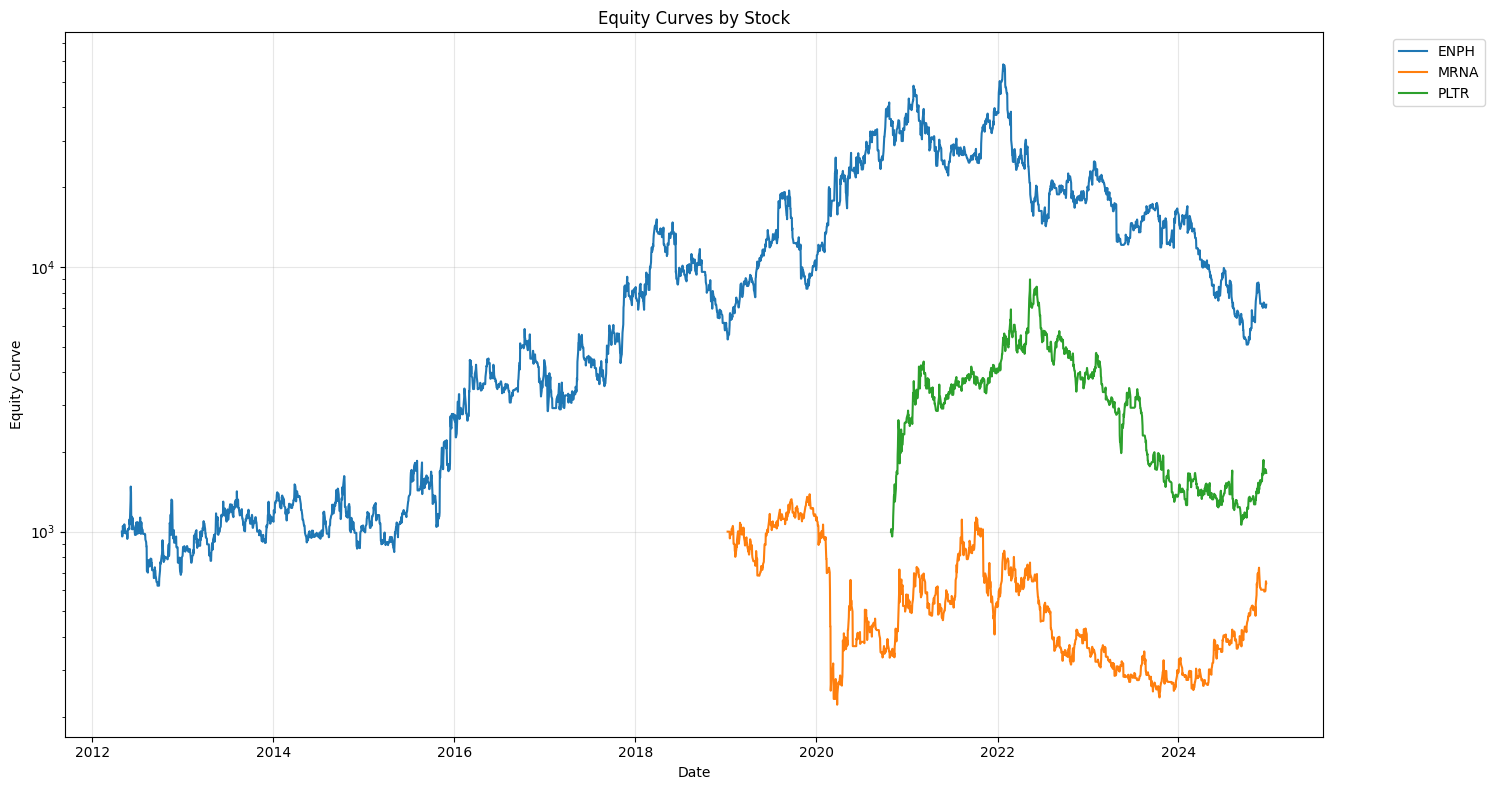

In [17]:
feature_cols = ['BodySize',
       '20_MA_Slope', 'RSI_Signal', 'Gap', 'Outside_Band', 'Short_Change',
       'Long_Change', 'Pct_Change_3_Months', 'Pct_Change_1_Month',
       '10_SMA_Slope', '50_SMA_Slope',
       'Above_50_SMA'
       ]

# Using top 3 stocks to reduce run time
results = optimize_strategy(
    df=df[df['Ticker'].isin(['ENPH','PLTR','MRNA'])],
    feature_columns=feature_cols,
    min_features=5,
    max_features=5,
    entry_thresholds=[0.3],
    exit_thresholds=[0],
    optimization_metric='mean_sharpe'
)

performance_df = analyze_best_strategy(results[0])